In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
import re
from sklearn.utils import shuffle
from sklearn import preprocessing
import pymc
from scipy import stats

%matplotlib inline  
plt.style.use('ggplot')

# Regression for Moore's Law
## Ridge Regression

In [2]:
# Load and preprocess data
X = []
Y = []

non_decimal = re.compile(r'[^\d]+')

for line in open('moore.csv'):
    r = line.split('\t')
    x = int(non_decimal.sub('', r[2].split('[')[0]))
    y = int(non_decimal.sub('', r[1].split('[')[0]))
    X.append(x)
    Y.append(y)

X = np.array(X)
Y = np.array(Y)
X.shape = (X.shape[0], 1)
Y = np.log(Y)

def preprocess_data(X, Y):    
    # split data into training and test set
    X, Y = shuffle(X, Y)
    N, M = X.shape
    idx = int(0.8*N)
    X_train = X[:idx, :]
    Y_train = Y[:idx]
    N_train = idx
    X_test = X[idx:, :]
    Y_test = Y[idx:]
    N_test = N - N_train

    # Normalize data
    train_mean = X_train.mean(axis=0)
    train_std = X_train.std(axis=0) 
    X_train = (X_train - train_mean) / train_std
    X_test = (X_test - train_mean) / train_std
    
    return X_train, Y_train, N_train, X_test, Y_test, N_test, M

(X_train, Y_train, N_train, X_test, Y_test, N_test, M) = preprocess_data(X, Y)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_36030b2f791b9c5af7b249ce0b9313d1 NOW.


Inference for Stan model: anon_model_36030b2f791b9c5af7b249ce0b9313d1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept        16.91  2.9e-3   0.18  16.54  16.79  16.91  17.02  17.27   4000    1.0
beta[0]           4.52  3.3e-3   0.18   4.14    4.4   4.52   4.64   4.88   3090    1.0
sigma             0.81  2.6e-3   0.14   0.59   0.71   0.79   0.89   1.15   3047    1.0
lambda            10.6     0.3  12.27   2.31   4.48    7.2  12.02   38.9   1671    1.0
Y_pred[0]        11.95    0.01   0.89  10.22  11.38  11.95  12.53  13.78   3822    1.0
Y_pred[1]        14.71    0.01   0.83  13.06  14.15  14.73  15.25  16.37   4000    1.0
Y_pred[2]        16.76    0.01   0.84  15.02  16.22  16.79  17.31  18.42   4000    1.0
Y_pred[3]         8.89    0.01   0.91    7.1   8.27   8.91   9.49  10.67   4000    1.0
Y_pred[4]        17.12    0.

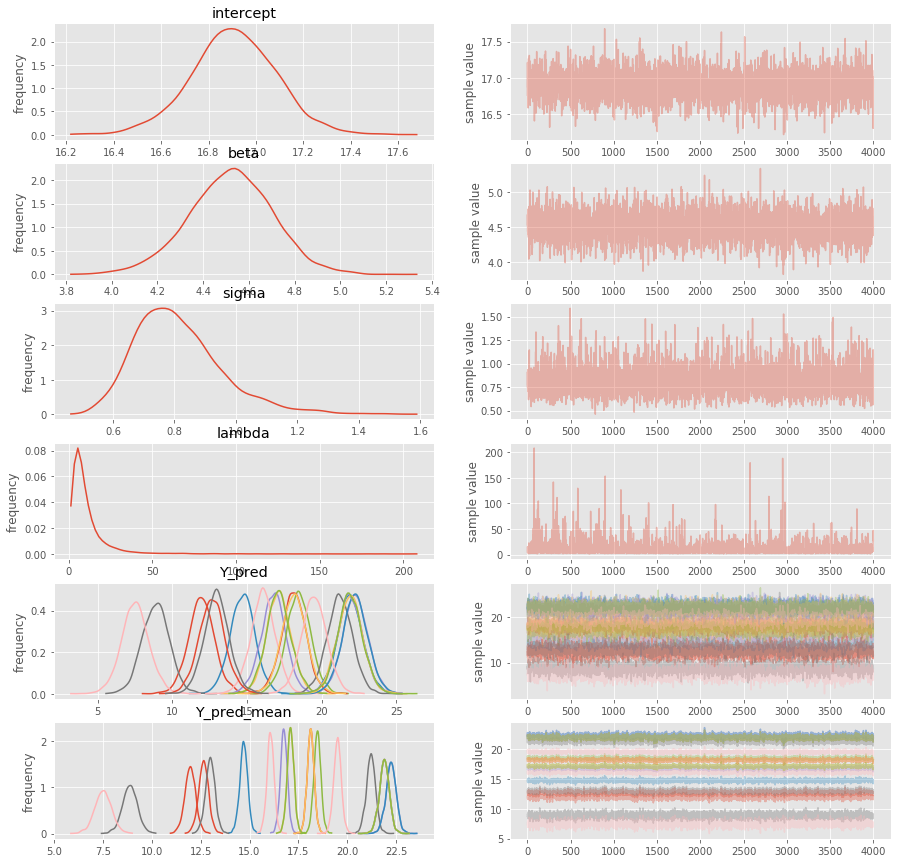

In [3]:
# Pystan model for Ridge Regression

ridge_code = """

data {
    int<lower=0> M; // number of predictors
    int<lower=0> N_train; // number of observations on training
    matrix[N_train, M] X_train; // predictors matrix for training
    vector[N_train] Y_train; // response vector for training
    int<lower=0> N_test; // number of observations on test
    matrix[N_test, M] X_test; // predictors matrix for test
}


parameters {
    real intercept;
    vector[M] beta;
    real<lower=0> sigma;
    real<lower=0> lambda;
}

model {
    vector[N_train] Y_mean;

    // Linear model
    Y_mean = X_train*beta + intercept;
    
    // Likelihood
    Y_train ~ normal(Y_mean, sigma);    
    
    // Priors
    intercept ~ normal(0, 10);
    beta ~ normal(0, lambda);
    sigma ~ cauchy(0, 10);
    lambda ~ cauchy(0, 10);
}

generated quantities {
    vector[N_test] Y_pred;
    vector[N_test] Y_pred_mean;
    
    Y_pred_mean = X_test*beta + intercept;
    for (i in 1:N_test)
        Y_pred[i] = normal_rng(Y_pred_mean[i], sigma); //the y values predicted by the model
}
"""

# dictionary containing data
data = {
    'X_train': X_test,
    'Y_train': Y_test,
    'N_train': N_test,
    'X_test': X_test,
    'N_test': N_test,
    'M': M
}

# fit model
ridge_fit = pystan.stan(model_code=ridge_code, data=data, iter=2000, chains=4)
print(ridge_fit)

fig = ridge_fit.plot()
fig.set_size_inches(15, 15)
Y_pred = ridge_fit.extract('Y_pred')['Y_pred']

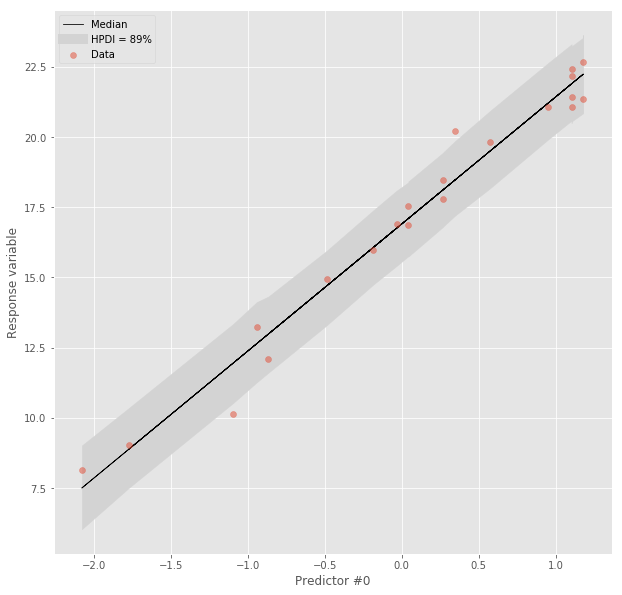

In [4]:
def prediction_plot(fit, pred_number=0):
    Y_hpdi = pymc.utils.hpd(Y_pred, 0.11)
    Y_lower = Y_hpdi[0, :]
    Y_upper = Y_hpdi[1, :]
    
    intercept = np.median(fit.extract('intercept')['intercept'])
    beta = np.median(fit.extract('beta')['beta'], axis=0)
    
    fig, ax = plt.subplots(1)
    fig.set_size_inches(10, 10)
    X_test_lin = X_test[:, pred_number]
    if not np.isscalar(beta):
        beta = beta[pred_number]
        
    Y_median = X_test_lin * beta + intercept
    
    ax.plot(X_test_lin, Y_median, linewidth=0.8, color='k', label='Median', zorder=2)
    ax.scatter(X_test_lin, Y_test, alpha=0.5, label='Data', zorder=3)
    sorted_x = X_test_lin.argsort()
    Y_upper = Y_upper[sorted_x]
    Y_lower = Y_lower[sorted_x]
    X_test_sorted = X_test_lin[sorted_x]
    ax.fill_between(X_test_sorted, Y_upper, Y_lower, color='lightgrey')
    ax.plot([], [], color='lightgrey', label='HPDI = 89%', linewidth=10)
    ax.legend(loc='upper left')
    plt.xlabel('Predictor #%d' % (pred_number))
    plt.ylabel('Response variable')    
    
prediction_plot(ridge_fit)

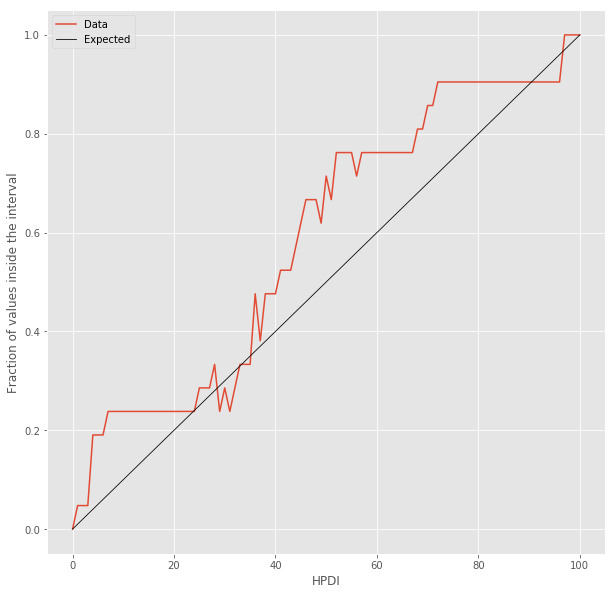

In [5]:
# Calibration curve
def calibration_curve(Y_pred, Y):
    calibration = np.zeros(101)
    for i in range(101):
        Y_hpdi = pymc.utils.hpd(Y_pred, max((100.0 - i) / 100.0, 1e-10))
        calibration[i] = ((Y >= Y_hpdi[0, :]) & (Y <= Y_hpdi[1, :])).mean()
    plt.figure(figsize=(10, 10))
    plt.plot(calibration, label='Data')
    line = np.linspace(0, 100, 100)
    plt.plot(line, line / 100.0, color='k', linewidth=0.8, label='Expected')
    plt.xlabel('HPDI')
    plt.ylabel('Fraction of values inside the interval')
    plt.legend(loc='upper left')
    
calibration_curve(Y_pred, Y_test)

def RMSE(Y_pred, Y_test):
    diff = (Y_pred - Y_test).flatten()
    return np.sqrt((diff.dot(diff)).mean())

In [6]:
print('RMSE = %.4e' %(RMSE(Y_pred, Y_test)))

RMSE = 3.2565e+02


## Lasso Regresion

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bf816625dbf7aab00ae5c2b50df84878 NOW.


Inference for Stan model: anon_model_bf816625dbf7aab00ae5c2b50df84878.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept        16.91  2.9e-3   0.18  16.55  16.79  16.91  17.03  17.26   4000    1.0
beta[0]           4.52  3.0e-3   0.19   4.12    4.4   4.52   4.64   4.88   4000    1.0
sigma             0.81  2.5e-3   0.15   0.59   0.71   0.79    0.9   1.15   3532    1.0
lambda            12.2    0.42  20.42   1.67   4.19   7.36  13.24  50.02   2319    1.0
Y_pred[0]        11.98    0.02   0.86  10.25  11.43  11.96  12.54  13.66   3179    1.0
Y_pred[1]        14.72    0.01   0.85  13.03  14.16  14.72  15.27   16.4   3764    1.0
Y_pred[2]        16.76    0.01   0.86  15.07   16.2  16.76  17.33  18.46   4000    1.0
Y_pred[3]         8.89    0.01   0.93   7.05    8.3   8.89   9.48  10.75   4000    1.0
Y_pred[4]        17.11    0.

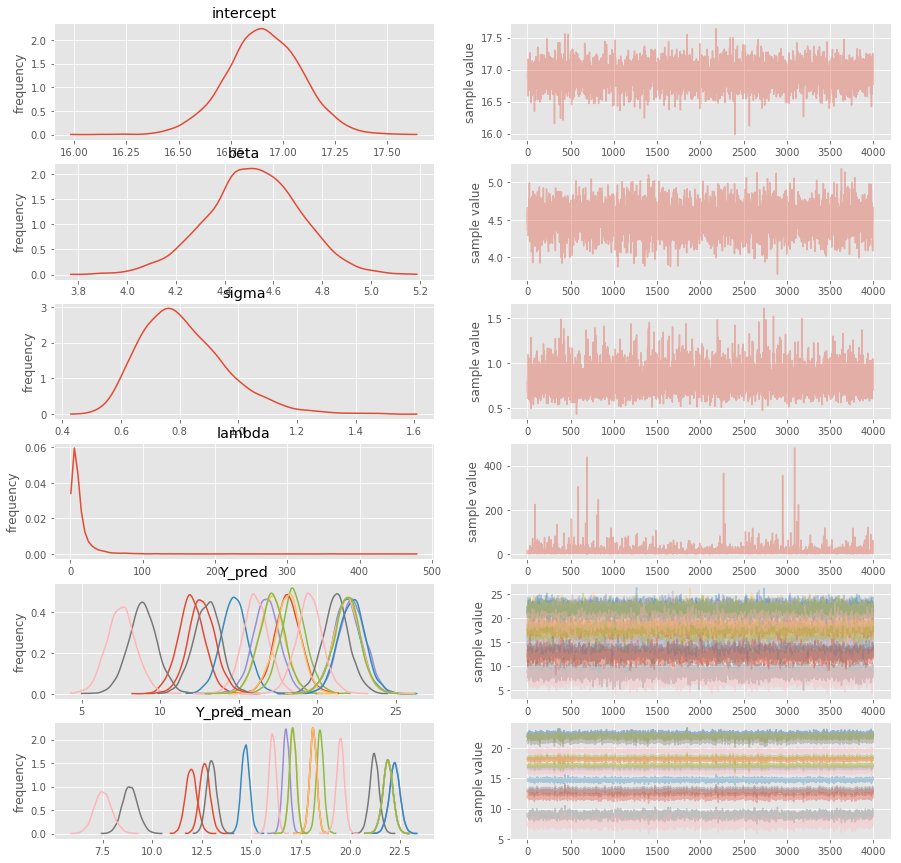

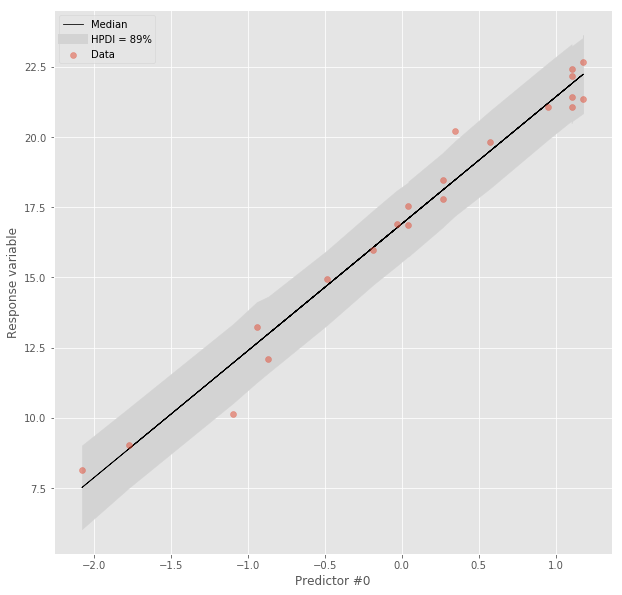

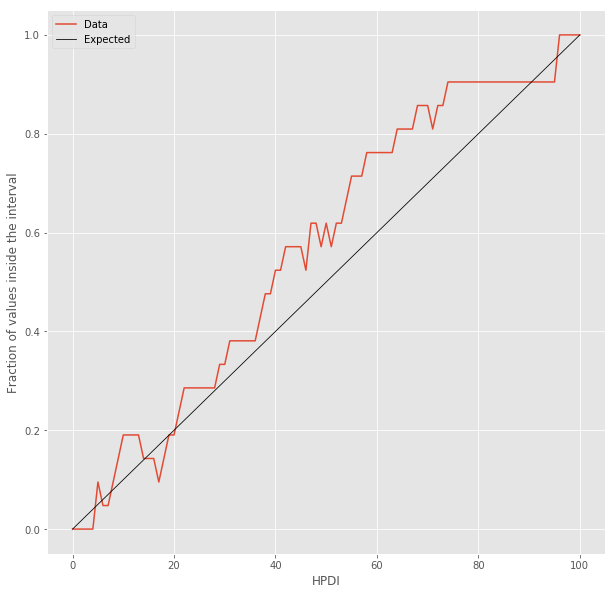

In [7]:
lasso_code = """

data {
    int<lower=0> M; // number of predictors
    int<lower=0> N_train; // number of observations on training
    matrix[N_train, M] X_train; // predictors matrix for training
    vector[N_train] Y_train; // response vector for training
    int<lower=0> N_test; // number of observations on test
    matrix[N_test, M] X_test; // predictors matrix for test
}


parameters {
    real intercept;
    vector[M] beta;
    real<lower=0> sigma;
    real<lower=0> lambda;
}

model {
    vector[N_train] Y_mean;

    // Linear model
    Y_mean = X_train*beta + intercept;
    
    // Likelihood
    Y_train ~ normal(Y_mean, sigma);    
    
    // Priors
    intercept ~ normal(0, 10);
    beta ~ double_exponential(0, lambda);
    sigma ~ cauchy(0, 10);
    lambda ~ cauchy(0, 10);
}

generated quantities {
    vector[N_test] Y_pred;
    vector[N_test] Y_pred_mean;
    
    Y_pred_mean = X_test*beta + intercept;
    for (i in 1:N_test)
        Y_pred[i] = normal_rng(Y_pred_mean[i], sigma); //the y values predicted by the model
}
"""

# fit model
lasso_fit = pystan.stan(model_code=lasso_code, data=data, iter=2000, chains=4)
print(lasso_fit)

fig = lasso_fit.plot()
fig.set_size_inches(15, 15)
prediction_plot(lasso_fit)
Y_pred = lasso_fit.extract('Y_pred')['Y_pred']
calibration_curve(Y_pred, Y_test)

In [8]:
print('RMSE = %.4e' %(RMSE(Y_pred, Y_test)))

RMSE = 3.2605e+02


## Robust Regression

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a1886ccc94022ca5d08f79196d33213a NOW.


Inference for Stan model: anon_model_a1886ccc94022ca5d08f79196d33213a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept        17.01  3.1e-3   0.16  16.67   16.9  17.02  17.12  17.31   2621    1.0
beta[0]           4.43  3.2e-3   0.18   4.11   4.31   4.43   4.54    4.8   2982    1.0
sigma             0.61  2.9e-3   0.15   0.39   0.51   0.59    0.7   0.96   2611    1.0
Y_pred[0]        12.16    0.01   0.67  10.79  11.74  12.17  12.58   13.5   3521    1.0
Y_pred[1]        14.86    0.01   0.66  13.56  14.44  14.85  15.26  16.17   4000    1.0
Y_pred[2]        16.87    0.01   0.66  15.57  16.45  16.87  17.29  18.23   3833    1.0
Y_pred[3]         9.14    0.01   0.74   7.66   8.69   9.15   9.63  10.58   3391    1.0
Y_pred[4]        17.21    0.01   0.65  15.94  16.78  17.21  17.62  18.54   4000    1.0
Y_pred[5]        18.55    0.

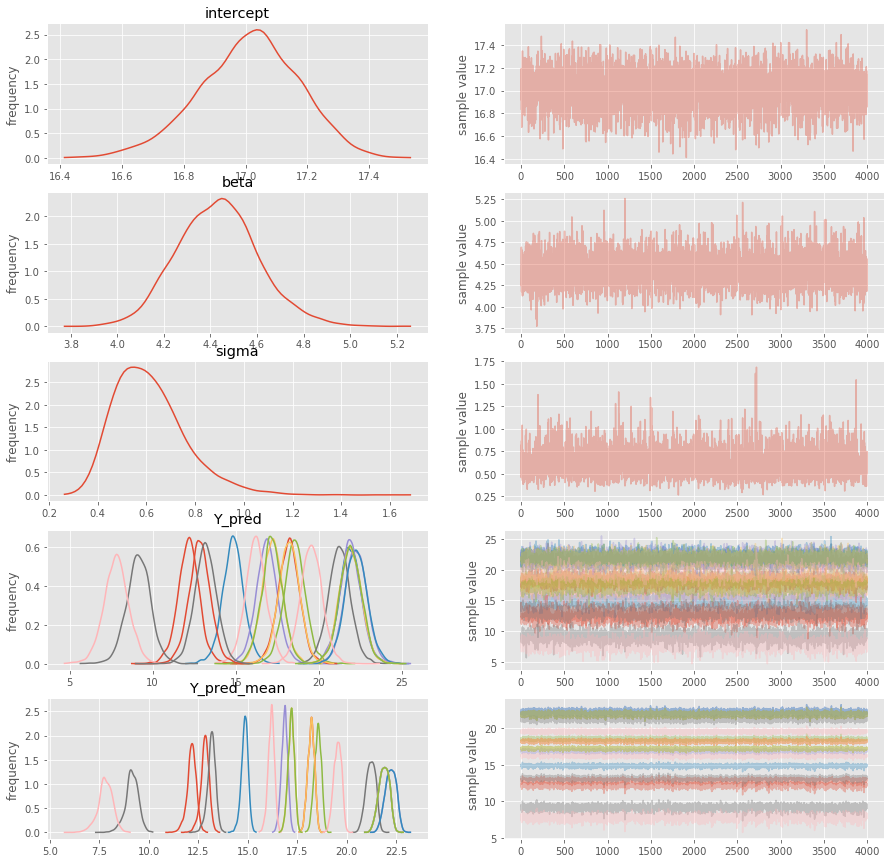

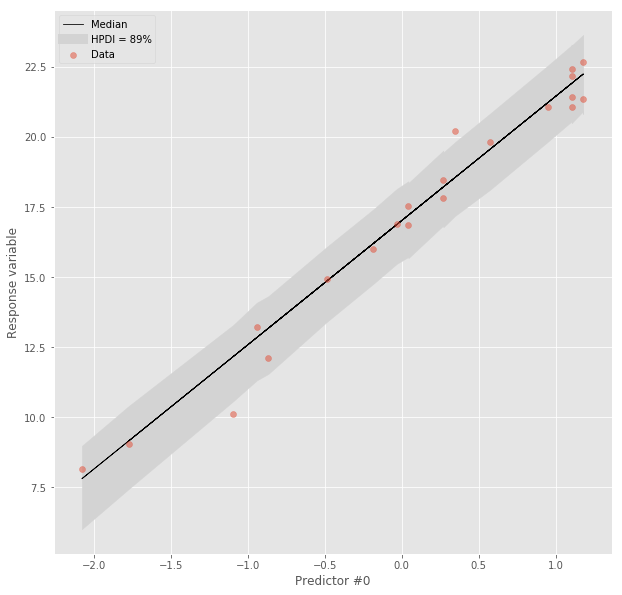

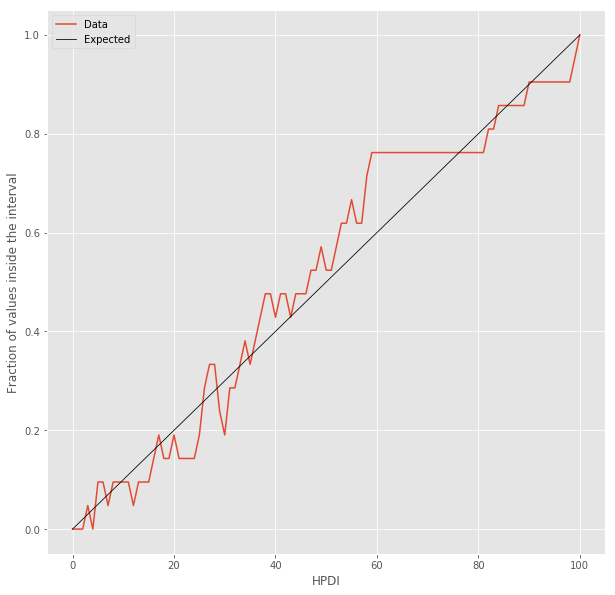

In [9]:
robust_code = """

data {
    int<lower=0> M; // number of predictors
    int<lower=0> N_train; // number of observations on training
    matrix[N_train, M] X_train; // predictors matrix for training
    vector[N_train] Y_train; // response vector for training
    int<lower=0> N_test; // number of observations on test
    matrix[N_test, M] X_test; // predictors matrix for test
}


parameters {
    real intercept;
    vector[M] beta;
    real<lower=0> sigma;
    //real<lower=0> lambda;
}

model {
    vector[N_train] Y_mean;

    // Linear model
    Y_mean = X_train*beta + intercept;
    
    // Likelihood
    Y_train ~ double_exponential(Y_mean, sigma);    
    
    // Priors
    intercept ~ normal(0, 10);
    beta ~ cauchy(0, 10);
    sigma ~ cauchy(0, 10);
}

generated quantities {
    vector[N_test] Y_pred;
    vector[N_test] Y_pred_mean;
    
    Y_pred_mean = X_test*beta + intercept;
    for (i in 1:N_test)
        Y_pred[i] = normal_rng(Y_pred_mean[i], sigma); //the y values predicted by the model
}
"""

# fit model
robust_fit = pystan.stan(model_code=robust_code, data=data, iter=2000, chains=4)
print(robust_fit)

fig = robust_fit.plot()
fig.set_size_inches(15, 15)
prediction_plot(robust_fit)
Y_pred = robust_fit.extract('Y_pred')['Y_pred']
calibration_curve(Y_pred, Y_test)

In [ ]:
print('RMSE = %.4e' %(RMSE(Y_pred, Y_test)))

RMSE = 2.8929e+02


## MAP Estimate

In [ ]:
map_code = """

data {
    int<lower=0> M; // number of predictors
    int<lower=0> N_train; // number of observations on training
    matrix[N_train, M] X_train; // predictors matrix for training
    vector[N_train] Y_train; // response vector for training
    int<lower=0> N_test; // number of observations on test
    matrix[N_test, M] X_test; // predictors matrix for test
}


parameters {
    real intercept;
    vector[M] beta;
    real<lower=0> sigma;
}

model {
    vector[N_train] Y_mean;

    // Linear model
    Y_mean = X_train*beta + intercept;
    
    // Likelihood
    Y_train ~ normal(Y_mean, sigma);    
    
    // Priors
    intercept ~ normal(0, 10);
    beta ~ cauchy(0, 20);
    sigma ~ cauchy(0, 10);
}

generated quantities {
    vector[N_test] Y_pred;
    vector[N_test] Y_pred_mean;
    
    Y_pred_mean = X_test*beta + intercept;
    for (i in 1:N_test)
        Y_pred[i] = normal_rng(Y_pred_mean[i], sigma); //the y values predicted by the model
}
"""

map_fit = pystan.StanModel(model_code=map_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0869c5092bd14e3015751434dedda93 NOW.


In [ ]:
map_params = map_fit.optimizing(data=data)

intercept = map_params['intercept']
beta = map_params['beta']
Y_pred = X_test * beta + intercept


# prediction curve
fig, ax = plt.subplots(1)
fig.set_size_inches(10, 10)
ax.scatter(X_test, Y_test, alpha=0.5, label='Data', zorder=3)
sorted_x = X_test[:, 0].argsort()
X_test_sorted = X_test[sorted_x, 0]
Y_pred_sorted = Y_pred[sorted_x]
Y_interval = stats.norm.interval(0.89, loc=Y_pred_sorted, scale=map_params['sigma'])
Y_lower = Y_interval[0]
Y_upper = Y_interval[1]
ax.plot(X_test_sorted, Y_pred_sorted, color='k', linewidth=0.8, label='MAP', zorder=2)
ax.plot([], [], color='lightgrey', label='Interval = 89%', linewidth=10)
ax.set_xlabel('Predictor #0')
ax.set_ylabel('Response variable') 
ax.fill_between(X_test_sorted, Y_upper[:, 0], Y_lower[:, 0], color='lightgrey', zorder=1)
ax.legend(loc='upper left')

# calibration curve
calibration = np.zeros(101)
for i in range(101):
    Y_interval = stats.norm.interval(float(i) / 100.0, loc=Y_pred, scale=map_params['sigma'])
    calibration[i] = ((Y_test.flatten() >= Y_interval[0].flatten()) & (Y_test.flatten() <= Y_interval[1].flatten())).mean()
plt.figure(figsize=(10, 10))
plt.plot(calibration, label='Data')
line = np.linspace(0, 100, 100)
plt.plot(line, line / 100.0, color='k', linewidth=0.8, label='Expected')
plt.xlabel('Interval')
plt.ylabel('Fraction of values inside the interval')
plt.legend(loc='upper left')


print('RMSE = %.4e' %(RMSE(Y_pred, Y_test)))